# Functions

In [2]:
using CSV
using Tables
using DataFrames
using Statistics
using LinearAlgebra
using Plots
using Optim
using NearestNeighbors
plotlyjs()


Plots.PlotlyJSBackend()

In [3]:
function ReadData_i(S,conf,pot)
    Λ = pot/5000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    diffstrat = "autodiff"
    problemName = "PB-S$S-O2-/$diffstrat/Yeoh/PL"
    for s in conf
        problemName = problemName*"_$s"
    end
    pot_10 = 10*pot
    problemName = problemName*"_ϕ$pot_10"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    x = _X[[1:101...],1]
    return x
end

ReadData_i (generic function with 1 method)

In [4]:
function isomap1(neighbors,Z_)
    n = length(eachcol(Z_))
    D_G = [[] for i in 1:n]
    # count = []
    # count2 = []
    Threads.@threads for i in 1:n
        d_G, prev_ = Dijkstra(Z_,i,neighbors)
        D_G[i] = d_G
        # push!(count,i)
        # ma = maximum(count)
        # push!(count2,ma)
        # mi = minimum(count2)
        # per = round(100*((ma-mi)/(n-mi)))
        # print("\r$ma - $mi - %$per")
    end
    D_G = reduce(hcat,D_G)
    D_G_sym = 0.5*(D_G+D_G')
    D_G_sq = D_G_sym.^2
    C = I - (1/n)*ones(n,n)
    B = -0.5*C*D_G_sq*C
    f(λ) = -real(λ)
    _iso = eigen(B, sortby=f)
    Λ_iso = real.(_iso.values)
    U_iso = real.(_iso.vectors)
    Λ_iso_m = diagm(sqrt.(Λ_iso[[1,2]]))
    U_iso_m = U_iso[:,[1,2]]
    X_iso = U_iso_m*Λ_iso_m
    return X_iso', D_G_sym
end

function Dijkstra(data,i,nieghbors)
    m, n = size(data)
    dist = [Inf64 for i in 1:n]
    prev = [0 for i in 1:n]
    nodes = data
    kdtree = KDTree(nodes; leafsize = 10)
    dist[i] = 0
    visited = []
    dist_ = copy(dist)
    while length(visited)<n
        # println(length(visited))
        u = argmin(dist_)
        append!(visited,u)
        distu = dist[u]
        idxs, dists = knn(kdtree, data[:,u], nieghbors, true,
        x -> maximum(isequal.(x,visited)))
        for i in 1:lastindex(idxs)
            alt = distu + dists[i]
            if alt<dist[idxs[i]]
                dist[idxs[i]]=alt
                prev[idxs[i]]=u
            end
        end
        dist_ = copy(dist)
        dist_[visited].=Inf64
    end
    return dist, prev
end

function kPOD(Κ,X,k)
    m, n = size(X)
    # X̄ = [1. for i in 1:n]
    # mean!(X̄',X)
    # for i in 1:n
    #     X[:,i] = X[:,i].-X̄[i]
    # end
    G = [Κ(X[:,i],X[:,j]) for i in 1:n, j in 1:n]
    # display(G)
    II = ones(n,n)
    Ḡ = G - (1/n)*G*II - (1/n)*II*G + (1/n^2)*II*G*II 
    # display(Ḡ)
    f(λ)=-abs(λ)
    Λ_ = eigen(Ḡ,sortby=f)
    Λ = Λ_.values
    U = Λ_.vectors
    Σ = diagm(real.(sqrt.(complex(Λ))))
    Σ_ = Σ[:,[1:k...]]
    U_ = U*pinv(Σ_')
    # U_ = U[:,1:k]
    return Λ, U, U_, Ḡ, G
end


kPOD (generic function with 1 method)

In [5]:
function plot_eigen(Λ)
    Λ = real.(Λ)
    Λ_t = sum(Λ)
    Λ = (1/Λ_t)*Λ
    Λ_s = round.(100*Λ[[i for i in 1:10]])
    p = bar(real.(Λ_s),xlabel="λ",ylabel="%", legend=false, hover=real.(Λ_s),
    xticks=collect(1:10),
    ylims=(0,100)
    )
    display(p)
end

plot_eigen (generic function with 1 method)

In [6]:
function VectorSearch(Z_,conf,list)
    n = length(list)
    z = Z_[:,list]
    v = [z[:,i]-Z_[:,1] for i in 1:n]
    z = Z_[:,1]
    for i in 1:Int(lastindex(conf)/2)
        for j in 1:4
            if conf[[(((i-1)*2)+1):(((i-1)*2)+2)...]] == digits(j-1,base=2,pad=2)
                z = z + v[((i-1)*4)+j]
            else
                z = z
            end
        end
    end
    return z
end

VectorSearch (generic function with 1 method)

# ROM Offline

## Data colection

### New Data

In [7]:
cd("C:/Users/mjbarillas/Documents/GitHub/Mimosa/")
S,conf,pot  = 4,[1,0,0,1,1,0,0,1],5000.0
x_i_ = ReadData_i(S,conf,pot);

In [ ]:
plot(x_i_,
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(conf) @ $pot V",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-0.02,0.02)
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB4S_FOS_10011001_5kV.svg")

In [8]:
x_i(conf) = ReadData_i(S,conf,pot)

x_i (generic function with 1 method)

In [9]:
Conf = []
for i1 in 0:1, i2 in 0:1, i3 in 0:1, i4 in 0:1, i5 in 0:1, i6 in 0:1, i7 in 0:1, i8 in 0:1
    push!(Conf,[i1,i2,i3,i4,i5,i6,i7,i8])
end


In [10]:
X = x_i.(Conf);

In [11]:
X = reduce(hcat,X)

101×256 Matrix{Float64}:
 0.0004   0.0004      0.0004      0.0004  …   0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004  …   0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 0.0004   0.0004      0.0004      0.0004      0.0004      0.0004      0.0004
 ⋮                                        ⋱                           ⋮
 0.0004  -0.00139559  0.00219559  0.0004     -0.0014128   0.0022128   0.0004
 0.0004  -0.00162074  0.00242074  0.0004     -0.00163881

In [ ]:
v = 79
plot(1000*X[:,v],
xlabel ="x (mm)",
ylabel = "y (mm)",
linewidth=4,
label="conf = $(conf[v]) @ $(P[1])",
legendfontsize=12,
guidefontsize=12,
tickfontsize=12,
# legend=:topleft,
ylims=(-25.0,25.0)
)

## kPCA

In [12]:
# Number of principal directions to be considered
k = 3
#Gaussian Kernel
β = 0.07216451173985709

0.07216451173985709

In [13]:
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
# Polynomial Kernel
# Κ(X1,X2) = (X1'*X2 + 10)^2
Λ, U, U_, Ḡ = kPOD(Κ, X, k)

(ComplexF64[0.5732232424279954 + 0.0im, 0.01270767830801799 + 0.0im, 0.001264266700330772 + 0.0im, 0.001264266575264576 + 0.0im, 0.00018723804488904208 + 0.0im, 1.862107589266267e-5 + 0.0im, 2.087751855243469e-6 + 0.0im, 8.178794081692716e-7 + 0.0im, 6.845821729404697e-7 + 0.0im, 3.483008698387299e-7 + 0.0im  …  4.435383886179285e-17 + 0.0im, -3.549299868572921e-17 + 0.0im, -2.9561289349109636e-17 + 0.0im, 8.064327551960276e-20 + 2.4407295244205685e-17im, 8.064327551960276e-20 - 2.4407295244205685e-17im, -2.3435762648028165e-17 + 0.0im, 1.3642857320990446e-17 + 3.3995693858412258e-18im, 1.3642857320990446e-17 - 3.3995693858412258e-18im, -7.547119760135064e-18 + 0.0im, 2.407078057626107e-18 + 0.0im], ComplexF64[1.4710960337581628e-13 + 0.0im 6.103277875006408e-14 + 0.0im … 0.07257767004452388 + 0.0im 0.05244533865170682 + 0.0im; -0.003092786780567139 + 0.0im -0.016582324047500093 + 0.0im … -0.06289454399612353 + 0.0im 0.051818059668542985 + 0.0im; … ; 0.0031261484565230204 + 0.0im 0.016

In [14]:
# Training Set in the reduced space
Z_ = real.(U_'*Ḡ)

3×256 Matrix{Float64}:
  1.11537e-13  -0.0023416    0.0023416   …   0.00236685  -2.90374e-13
  6.46036e-15  -0.0018693    0.0018693       0.00188376  -1.39414e-14
 -0.0019606    -0.00195385  -0.00195389     -0.00195376  -0.0019606

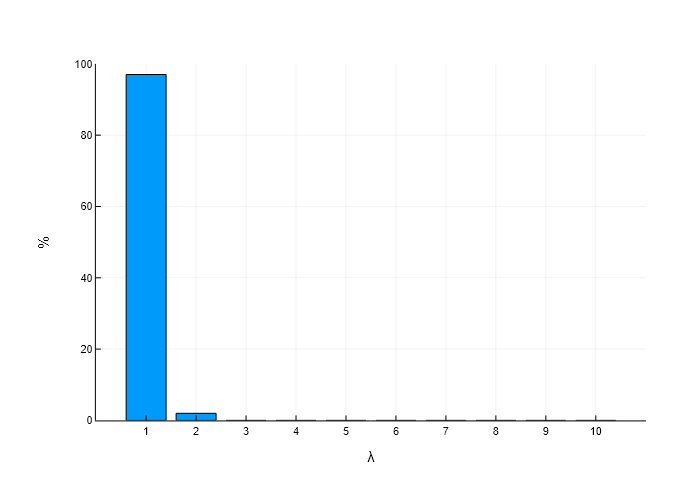

In [15]:
plot_eigen(Λ)

In [16]:
gr()

Plots.GRBackend()

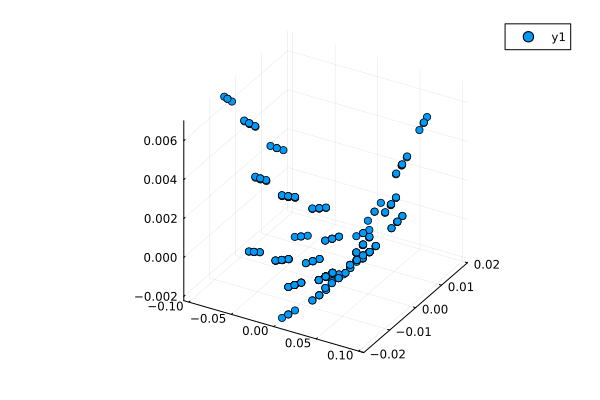

In [17]:
scatter(eachrow(Z_)...)

## Fit surface for visualization

In [ ]:
# -------Curve fitting------
# Quadric surface explicit in z3 of the form z3 = A + B*z1^2 + Cz2^2 + D*z1 + E*z2
Quadric(z) = [1 z[1]^2 z[2]^2 z[1] z[2]] 

# least squares fit of the curve to the TS in the RS
A = [Quadric(Z) for Z in eachcol(Z_)]
A = reduce(vcat,A)
c = pinv(A)*Z_[3,:]

#Definition of surface and unit gradient
z3(z1,z2) = c[1] + c[2]*z1^2 + c[3]*z2^2 + c[4]*z1 + c[5]*z2
∇zᵤ(z1,z2) = (1/norm([2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]))*[2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]

In [ ]:
gr()

In [ ]:
wireframe(
    round(minimum(Z_[1,:]),digits=3):0.005:round(maximum(Z_[1,:]),digits=3),
    round(minimum(Z_[2,:]),digits=3):0.005:round(maximum(Z_[2,:]),digits = 3),
    z3)

In [ ]:
scatter!(eachrow(Z_)...;xlabel="z₁",ylabel="z₂",zlabel="z₃", 
    # hover= [i for i in 1:lastindex(eachcol(Z_))],
    markercolor = [1 for _ in 1:256], #[c[4] for c in conf],
    size=(1200,1200),
    label = false,
    grid = true, gridlinewidth = 2,
    tickfontsize = 20,
    guidefontsize=30,
    zticks=[round(minimum(Z_[3,:]),digits=3),0.0,round(maximum(Z_[3,:]),digits=3)...],
    xticks=[round(minimum(Z_[1,:]),digits=3),0.0,round(maximum(Z_[1,:]),digits=3)...],
    yticks=[round(minimum(Z_[2,:]),digits=3),0.0,round(maximum(Z_[2,:]),digits=3)...],
    markersize = 4
    )

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB4S_kPCA_5kV.svg")

In [ ]:
# Scatter plot of the TS in RS
scatter(eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3", 
hover= [i for i in 1:lastindex(eachcol(Z_))])


## Isomap

In [18]:
neighbors = 100
Y_, D_G_sym = isomap1(neighbors,Z_)


([-1.095044393647165e-9 0.0023529207415934265 … -0.0023757350251360884 -1.0946762387835014e-9; 2.8100498171925175e-10 0.002086418487821459 … -0.0020950896831702943 2.8084118936988257e-10], [0.0 0.002996229210690636 … 0.0030249947883797352 4.0243612809825495e-13; 0.002996229210690636 0.0 … 0.006021207035238994 0.0029962292103638145; … ; 0.0030249947883797352 0.006021207035238994 … 0.0 0.003024994788706914; 4.0243612809825495e-13 0.0029962292103638145 … 0.003024994788706914 0.0])

In [24]:
plotlyjs()

Plots.PlotlyJSBackend()

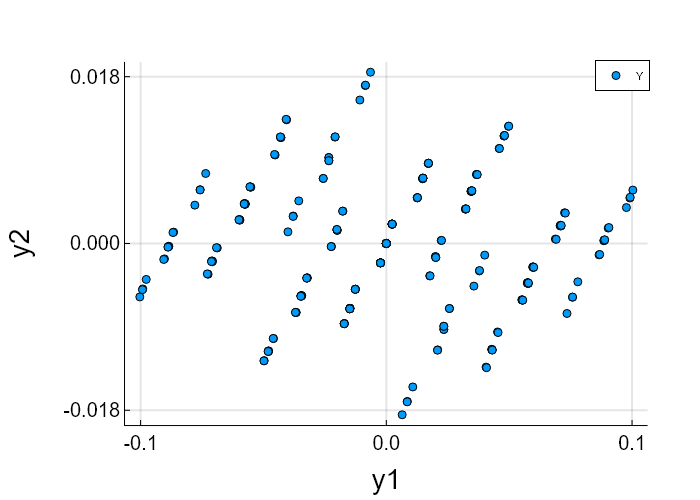

In [25]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
    markercolor = [1 for _ in 1:256], #[c[4] for c in conf],
    size=(1000,800),
    hover=collect(1:256),
    grid = true, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=20,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
    label="Y"
)

In [30]:
conf = Conf[:,group[10]]

8-element Vector{Int64}:
 0
 0
 0
 0
 0
 1
 0
 0

In [83]:
r = 1.1*norm(Y_[:,192]-Y_[:,130])
kdtree = KDTree(Y_; leafsize = 10)
group = inrange(kdtree,Y_[:,192],r)

16-element Vector{Int64}:
 141
 192
 129
 177
 180
 189
 190
 178
 142
 130
 131
 143
 179
 191
 144
 132

In [66]:
r = 1.1*norm(Y_[:,256]-Y_[:,254])
kdtree = KDTree(Y_; leafsize = 10)
group = inrange(kdtree,Y_[:,256],r)

32-element Vector{Int64}:
 256
  16
 196
  52
  64
  61
   4
 205
 253
   1
   ⋮
 206
 243
  51
 195
   3
 255
  15
 207
  63

In [41]:
gr()

Plots.GRBackend()

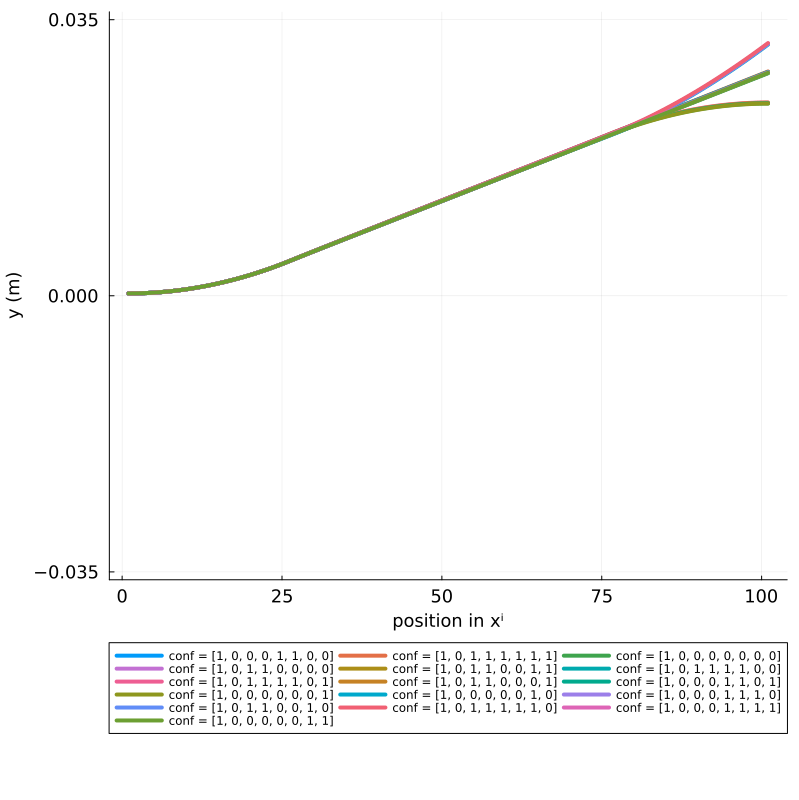

In [85]:
x_i_ = X[:,group[1]]
conf = Conf[:,group[1]]
plot(x_i_,
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(conf)",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:outerbottom,
ylims=(-0.036,0.036),
size=(800,800),
legendcolumns=3,
yticks=[-0.035,0.0,0.035]
)
p = nothing
for i in 2:lastindex(group) 
    x_i_ = X[:,group[i]]
    conf = Conf[:,group[i]]
    p = plot!(x_i_,
    xlabel ="position in xⁱ",
    ylabel = "y (m)",
    linewidth=4,
    label="conf = $(conf)",
    legendfontsize=8,
    guidefontsize=12,
    tickfontsize=12,

    )
end
display(p)

In [86]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB4S_cluster4_5kV.svg")

"G:\\My Drive\\Temp\\Comunication\\ROM_Paper\\PB4S_cluster4_5kV.svg"

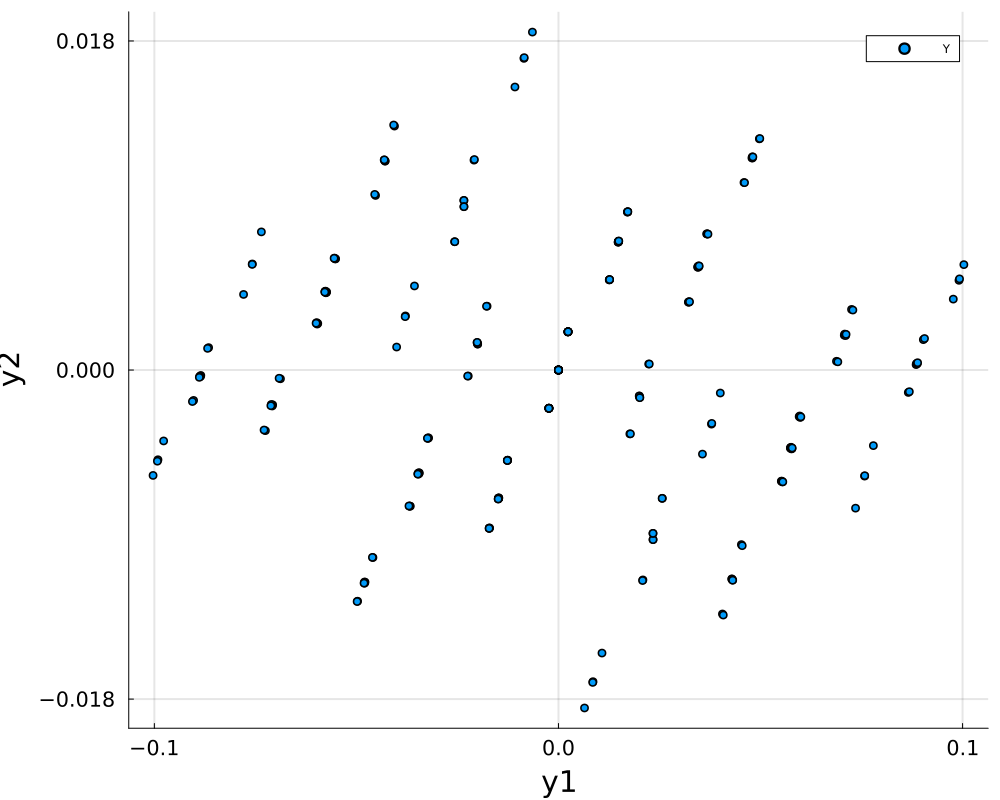

In [19]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
    markercolor = [1 for _ in 1:256], #[c[4] for c in conf],
    size=(1000,800),
    # label = false,
    grid = true, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=20,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
    label="Y"
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB4S_isomap_5kV.svg")

In [20]:
Conf = reduce(hcat,Conf)

8×256 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  1  1  1  1  1     0  0  0  0  1  1  1  1  1  1  1  1
 0  0  0  0  1  1  1  1  0  0  0  0  1  …  1  1  1  1  0  0  0  0  1  1  1  1
 0  0  1  1  0  0  1  1  0  0  1  1  0     0  0  1  1  0  0  1  1  0  0  1  1
 0  1  0  1  0  1  0  1  0  1  0  1  0     0  1  0  1  0  1  0  1  0  1  0  1

In [21]:
conf_a = [digits(i-1,base=2,pad=2) for i in 1:4]
conf_a = reduce(hcat,conf_a)
conf_VS = hcat(vcat(conf_a,zeros(6,4)),vcat(zeros(2,4),conf_a,zeros(4,4)),vcat(zeros(4,4),conf_a,zeros(2,4)),vcat(zeros(6,4),conf_a))

# n,m = size(Conf)
VS_list = []
for c in eachcol(conf_VS)
    count = 1
    for cc in eachcol(Conf)
        if c==cc
            push!(VS_list,count)
            break
        end
        count += 1
    end
end

In [ ]:
VectorSearch(Y_,[1,0,0,1,1,0,0,1],VS_list)

In [22]:
Y_gen = []
for conf in eachcol(Conf)
    y_gen = VectorSearch(Y_,conf,VS_list)
    push!(Y_gen,y_gen)
end
Y_gen = reduce(hcat,Y_gen)

2×256 Matrix{Float64}:
 -1.09504e-9   0.00235292  -0.00235292  …  -0.00235292  -1.09511e-9
  2.81005e-10  0.00208642  -0.00208642     -0.00208642   2.81007e-10

In [23]:
Err = norm(Y_gen-Y_)/norm(Y_)

0.03884467494325179

In [ ]:
s = scatter!(eachrow(Y_gen)...,xlabel="y1",ylabel="y2",
    label="Y* (ERR_TS = $(round(Err*100,digits=2))%)",legend=:outerbottom,legend_columns=2,
    size=(1000,800),
    grid = true, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=20,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
)

## Optimization of the $\beta$ parameter

In [ ]:
function Objective(β)
    println("β = $β")
    # Number of principal directions to be considered
    k = 3
    #Gaussian Kernel
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    #kPCA
    Λ, U, U_, Ḡ = kPOD(Κ, X, k)
    # Training Set in the reduced space
    Z_ = real.(U_'*Ḡ)
    neighbors = 100
    Y_, D_G_sym = isomap1(neighbors,Z_)
    #Generation of full set of parameters in order
    Y_gen = []
    for conf in eachcol(Conf)
        y_gen = VectorSearch(Y_,conf,VS_list)
        push!(Y_gen,y_gen)
    end
    Y_gen = reduce(hcat,Y_gen)
    Err = norm(Y_gen-Y_)/norm(Y_)
    println("Error = $Err")
    return Err
end

In [ ]:
β_min = optimize(Objective, 0.0, 10.0, GoldenSection(),f_tol=1.0e-6,iterations=50)

In [ ]:
β_min.minimizer

## Plots

In [ ]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
label="TS PB4S",legend=:outerbottom,
# legend_columns=2,
markercolor = [c[1] for c in conf],
hover= [i for i in 1:lastindex(eachcol(Z_))]
)

In [ ]:
gr()

In [ ]:
plotlyjs()

In [ ]:

function plot_vector1(i)
    plot!(eachrow(Y_[:,VS_Conf_list[[1,i]]])...,arrow=true,label=false,color=:black,
    )
    s = annotate!(eachrow(1.2*Y_[:,VS_Conf_list[[1,i]]])...,["", ("$(-(conf[VS_Conf_list[i]].-2))",8)]
    )
    return s
end
function plot_vector2(i)
    plot!(eachrow(Y_[:,[81,i]])...,arrow=true,label=false,color=:black,
    )
    s = annotate!(eachrow([1.15 0;0 1]*Y_[:,i])...,["", ("$(-(conf[i].-2))", 8)]
    )
    return s
end

In [ ]:
plot!(eachrow(Y_[:,VS_Conf_list[[1,3]]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[81,21]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[81,21]])...,arrow=true,label=false
)
plot!(eachrow(Y_[:,[27,21]])...,arrow=true,label=false
)

In [ ]:
scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
label=false
)
plot_vector1(6)
plot_vector1(7)
s = plot_vector2(45)
plot!(eachrow(Y_[:,[VS_Conf_list[6],45]])...,arrow=false,label=false,color=:black,
line = :dash
)
plot!(eachrow(Y_[:,[VS_Conf_list[7],45]])...,arrow=false,label=false,color=:black,
line = :dash
)
xlims!(1.1*minimum(Y_[1,:]),1.1*maximum(Y_[1,:]))
ylims!(1.1*minimum(Y_[2,:]),1.1*maximum(Y_[2,:]))